<a href="https://colab.research.google.com/github/nazmus007/transformers_test/blob/main/electra_ptacek_mosesmwong_run2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install -qq transformers


     |████████████████████████████████| 2.9 MB 7.1 MB/s 
     |████████████████████████████████| 636 kB 81.0 MB/s 
     |████████████████████████████████| 3.3 MB 79.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 895 kB 85.6 MB/s 


In [ ]:
!pip install emoji

     |████████████████████████████████| 168 kB 7.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.0-py3-none-any.whl size=168256 sha256=395d450026c6848b0177512825f0312b5f2087cf821f5759fc4ef6c76b8c085b
  Stored in directory: /root/.cache/pip/wheels/f7/d7/74/c720aaf345a042b0c2d74361873258c5e8649b7f11b2ccce49
Successfully built emoji


In [ ]:
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from transformers import get_linear_schedule_with_warmup
from torch import nn, optim
import seaborn as sns
from emoji import UNICODE_EMOJI
from sklearn.metrics import confusion_matrix
from torch.nn import functional as F 
from pylab import rcParams
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW #

import matplotlib.pyplot as plt

from matplotlib import rc
import torch

import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("./drive/MyDrive/datasets/cleaned_ptacek_wtweets_wnotebook.csv")
df.head()

,Unnamed: 0,index,Tweet_id,Tweet,Label
0,0,0,411348816583856129,peyton obviously cannot finish games he just t...,1
1,1,1,408111537011036160,well i would love to be sleeping right now but...,1
2,2,2,403282506230665217,my biggest executive decision today choosing b...,1
3,3,3,409720467662983168,the first quality opponent they played in 2 y...,1
4,4,4,403005765608554496,but do not you dare call it hate crimes libe...,1


In [ ]:
df= df.drop(['Unnamed: 0','index','Tweet_id'],axis=1)

In [ ]:
df_train = pd.read_csv('./drive/MyDrive/datasets/df_train.csv')

df_test = pd.read_csv('./drive/MyDrive/datasets/df_test.csv') 

In [ ]:
#Hyperparameters
my_learning_rate = 2E-5 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-8
my_number_of_epochs = 5
my_warmup = 3
my_mini_batch_size = 32

In [ ]:
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
!pip install demoji

     |████████████████████████████████| 42 kB 1.3 MB/s 


In [ ]:
import demoji
def demoji_text(text):
  d= demoji.findall(text)
  return d

In [ ]:
df['emoji_list'] = df['Tweet'].apply(demoji_text)

In [ ]:
f= list(filter(None, df['emoji_list']))

In [ ]:
print(f)

[{'😏': 'smirking face', '👌': 'OK hand'}, {'👍': 'thumbs up'}, {'😡': 'pouting face'}, {'😫': 'tired face', '🙈': 'see-no-evil monkey', '🔫': 'water pistol', '😍': 'smiling face with heart-eyes'}, {'😐': 'neutral face'}, {'😒': 'unamused face'}, {'😮': 'face with open mouth', '👀': 'eyes'}, {'🔫': 'water pistol', '😭': 'loudly crying face'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'👌': 'OK hand', '😳': 'flushed face'}, {'😣': 'persevering face'}, {'😒': 'unamused face'}, {'👌': 'OK hand'}, {'😒': 'unamused face'}, {'🙈': 'see-no-evil monkey'}, {'😒': 'unamused face'}, {'😊': 'smiling face with smiling eyes'}, {'👌': 'OK hand'}, {'😑': 'expressionless face'}, {'👍': 'thumbs up'}, {'🎉': 'party popper'}, {'😒': 'unamused face', '👏': 'clapping hands'}, {'😛': 'face with tongue'}, {'😒': 'unamused face'}, {'😻': 'smiling cat with heart-eyes'}, {'😑': 'expressionless face'}, {'😰': 'anxious face with sweat'}, {'😉': 'winking face'}, {'😳': 'flushed face'}, {'😭': 'loudly crying face'}, {'💁': 'person tipping hand'}, {'😤':

In [ ]:
all_keys = set().union(*(d.keys() for d in f))

In [ ]:
print(all_keys)

{'🎹', '🇫🇷', '⏰', '🚙', '☀️', '🍝', '😛', '🎺', '💥', '📯', '🐣', '🎸', '🍏', '🌽', '💔', '😰', '🍉', '🚗', '©', '✌', '✋', '💯', '🚶', '😷', '▪', '😊', '🎷', '🙍', '🍠', '☝️', '🎓', '🔥', '👫', '🎥', '🔫', '✈️', '▶', '🍈', '🙈', '😏', '😬', '🎉', '🎼', '🐽', '🇺🇸', '🐥', '®', '👩', '☺️', '🎨', '💄', '😙', '👪', '👬', '🏄', '🚬', '🍆', '🚓', '☺', '🎾', '🐶', '📀', '⛅', '👼', '😻', '🍸', '☹', '💊', '😋', '😪', '💀', '😡', '👍', '🆒', '🌙', '💻', '❄️', '📣', '🍟', '💎', '💤', '😎', '😣', '🌀', '🍃', '👳', '😹', '🏈', '🌁', '👉', '👱', '💨', '😃', '😌', '👑', '🚺', '😴', '😺', '🍍', '🎶', '🍤', '🍨', '🎵', '😓', '🙊', '💕', '🍪', '🍕', '😦', '☕', '💗', '◽', '🎮', '💵', '💙', '🇬🇧', '💦', '🕑', '🍷', '👅', '🐭', '🐒', '😑', '🌱', '⛄', '🎌', '➡️', '😅', '🐾', '👐', '💸', '™', '😽', '👔', '🎻', '☠', '📺', '❄', '🌂', '🐇', '😜', '💣', '🍫', '🇮🇹', '🏥', '🏊', '🐧', '💂', '😉', '🐸', '🌾', '🐷', '💞', '🍧', '👏', '😚', '😒', '🎅', '👠', '😟', '👆', '🐤', '🍗', '😯', '😧', '🚔', '😢', '✴', '🙉', '🌏', '💪', '🇩🇪', '👶', '🎆', '😄', '♥️', '🚴', '😲', '📖', '🌵', '😈', '❗', '🐼', '🐳', '👻', '🍳', '😩', '🐛', '🍵', '🔯', '🍩', '✔️', '🙏', '🍭', '🌚', '😔', '💖', '

In [ ]:
import emoji
def extract_emojis(s):
    return ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in s)

In [ ]:
df['Tweet'] = df['Tweet'].apply(extract_emojis)

In [ ]:
df_train['Tweet'] = df_train['Tweet'].apply(extract_emojis)

df_test['Tweet'] = df_test['Tweet'].apply(extract_emojis)


In [ ]:
df.to_csv('./drive/MyDrive/datasets/file1.csv')

In [ ]:
df.columns = df.columns.str.lstrip()

In [ ]:

texts = df_train.Tweet.values
labels = df_train.Label.values

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator') 
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2,return_dict= True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

In [ ]:
emoji_1 = re.compile('[\\u203C-\\u3299\\U0001F000-\\U0001F644]')

In [ ]:
emoji_list= list(filter(emoji_1.match, df['Tweet']))

NameError: ignored

In [ ]:
print(emoji_list)

NameError: ignored

In [ ]:
emo_found= ' '.join(emoji for emoji in emoji_list)

NameError: ignored

In [ ]:

def get_emoji_set(text):
    return {letter for letter in text if letter in UNICODE_EMOJI['en'] }

In [ ]:
c = get_emoji_set(emo_found)

In [ ]:
print(c)

{'▶', '⛄', '🙉', '👌', '👑', '😘', '😳', '🏥', '⭐', '😂', '😩', '😔', '☕', '👫', '🍀', '🙈', '💣', '💦', '🎄', '✨', '🎀', '☺', '🌍', '🍊', '🌏', '😙', '😏', '😕', '😊', '🎶', '💎', '🐉', '🎧', '🎅', '❄', '💕', '😒', '💯', '😝', '❤', '😛', '🐒', '😋', '👼', '🏈', '💗', '🐶', '😇', '🐸', '🙊', '🎎', '😢', '😍', '🐾', '🍩', '💊', '♥', '📱', '😆', '💝', '🎁', '🌞', '🍃', '☹', '🍻', '🎈', '😱', '💚'}


In [ ]:
tokenizer.add_tokens(['🎹', '🇫🇷', '⏰', '🚙', '☀️', '🍝', '😛', '🎺', '💥', '📯', '🐣', '🎸', '🍏', '🌽', '💔', '😰', '🍉', '🚗', '©', '✌', '✋', '💯', '🚶', '😷', '▪', '😊', '🎷', '🙍', '🍠', '☝️', '🎓', '🔥', '👫', '🎥', '🔫', '✈️', '▶', '🍈', '🙈', '😏', '😬', '🎉', '🎼', '🐽', '🇺🇸', '🐥', '®', '👩', '☺️', '🎨', '💄', '😙', '👪', '👬', '🏄', '🚬', '🍆', '🚓', '☺', '🎾', '🐶', '📀', '⛅', '👼', '😻', '🍸', '☹', '💊', '😋', '😪', '💀', '😡', '👍', '🆒', '🌙', '💻', '❄️', '📣', '🍟', '💎', '💤', '😎', '😣', '🌀', '🍃', '👳', '😹', '🏈', '🌁', '👉', '👱', '💨', '😃', '😌', '👑', '🚺', '😴', '😺', '🍍', '🎶', '🍤', '🍨', '🎵', '😓', '🙊', '💕', '🍪', '🍕', '😦', '☕', '💗', '◽', '🎮', '💵', '💙', '🇬🇧', '💦', '🕑', '🍷', '👅', '🐭', '🐒', '😑', '🌱', '⛄', '🎌', '➡️', '😅', '🐾', '👐', '💸', '™', '😽', '👔', '🎻', '☠', '📺', '❄', '🌂', '🐇', '😜', '💣', '🍫', '🇮🇹', '🏥', '🏊', '🐧', '💂', '😉', '🐸', '🌾', '🐷', '💞', '🍧', '👏', '😚', '😒', '🎅', '👠', '😟', '👆', '🐤', '🍗', '😯', '😧', '🚔', '😢', '✴', '🙉', '🌏', '💪', '🇩🇪', '👶', '🎆', '😄', '♥️', '🚴', '😲', '📖', '🌵', '😈', '❗', '🐼', '🐳', '👻', '🍳', '😩', '🐛', '🍵', '🔯', '🍩', '✔️', '🙏', '🍭', '🌚', '😔', '💖', '😮', '👸', '🐠', '🌸', '💝', '💍', '💋', '💅', '😶', '💜', '👰', '🍛', '🌆', '🌲', '🔆', '🍔', '⚡', '☀', '🎄', '❤️', '😂', '🔞', '❤', '👹', '👯', '💧', '💉', '🔪', '🚀', '🎋', '🕐', '🙀', '📱', '👙', '📑', '💳', '😞', '👃', '✈', '👀', '💛', '💢', '🍅', '☂', '😕', '🍀', '😝', '🚫', '💟', '🎤', '📄', '🌅', '✏', '☁', '♦', '📚', '😍', '🌍', '😖', '👣', '🚨', '🍻', '💏', '⚽', '👜', '👌', '😐', '🍬', '😀', '🍦', '💘', '😱', '🎁', '💆', '✊', '♏', '🙅', '🐰', '💩', '👊', '🕥', '👎', '✨', '🏃', '🍲', '😿', '💃', '🐴', '🙌', '🙆', '🏂', '🐬', '👭', '🌠', '🎀', '🍁', '🔅', '🍊', '🙋', '🏡', '📓', '🎭', '❌', '👈', '😨', '🆘', '〰', '😠', '🎈', '✖', '✌️', '😳', '☃', '💁', '👾', '🌊', '🌴', '🍺', '🌻', '◾', '🏰', '🚢', '☮', '👋', '☁️', '👄', '💌', '👿', '🐟', '👂', '🌌', '😗', '🔄', '🍓', '💐', '🌞', '☔', '😤', '⁉️', '✖️', '😫', '🐉', '😘', '🍋', '😭', '😆', '😁', '💚', '🍰', '😵', '💼', '🎂', '⬅️', '🔮', '🍖', '🍹', '😇', '🎎', '🎿', '🌃', '📨', '♥', '💰', '🎧', '💽', '⛪', '⭐', '🎊', '🌎', '😥', '🚼']
)

362

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(30884, 768)

In [ ]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30884, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
indices=tokenizer.batch_encode_plus(texts,
                                    max_length=64,
                                    add_special_tokens=True, 
                                    return_attention_mask=True,
                                    pad_to_max_length=True,
                                    truncation=True)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


In [ ]:
batch_size = my_mini_batch_size

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = my_learning_rate, #args.learning_rate
                  eps = my_adam_epsilon  #args.adam_epsilon
                )


In [ ]:
epochs = my_number_of_epochs

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = my_warmup, 
                                            num_training_steps = total_steps)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Base on GLUE from huggingface, this is classification problem best suit our problem, here, look at the
# example Python code from hungingface gtihub, here is the here training loop

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [ ]:
loss_values = []
train_acc = []
# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    #correct_prediction= 0
    history = defaultdict(list)
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        #logits = outputs[1]
        #_, preds = torch.max(outputs, dim=1)
        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        #correct_predictions += torch.sum(preds == b_labels)
        loss.backward()
        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        logits = outputs.logits
        #logits = F.softmax(logits, dim= -1)
        #logits= torch.nn.Softmax(logits)
        logits = logits.detach().cpu().numpy()
        num_correct = (torch.max(outputs[1], 1)[1] == b_labels.data).float().sum()
        acc = (100 * num_correct )/ 32
        train_acc.append(acc.item())
        #avg_train_acc =sum(train_acc)/len(train_acc)
        #labels = b_labels.to('cpu').numpy()
        #tmp_train_accuracy = flat_accuracy(logits, labels)
        #train_acc += tmp_train_accuracy
        #conf_mat = confusion_matrix(logits, labels)
        #acc = np.sum(conf_mat.diagonal()) / np.sum(conf_mat)
        #print('Train accuracy: {} %'.format(acc*100))
    # Calculate the average loss over the training data.

    avg_train_loss = total_loss / len(train_dataloader)   
             
    # train_acc= correct_predictions.double() / len(train_dataloader)

    history['train_loss'].append(loss.item())
    history['train_acc'].append(acc.item())
    # Store the loss value for plotting the learning curve.
    #loss_values.append(avg_train_loss)
    
    print("")
    print("Training accuracy: {}".format(train_acc))
    print("  Average training loss:{0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))

   
#    plt.ylim([0, 1]);
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of  1,285.    Elapsed: 0:00:10.
  Batch   100  of  1,285.    Elapsed: 0:00:21.
  Batch   150  of  1,285.    Elapsed: 0:00:31.
  Batch   200  of  1,285.    Elapsed: 0:00:41.
  Batch   250  of  1,285.    Elapsed: 0:00:52.
  Batch   300  of  1,285.    Elapsed: 0:01:02.
  Batch   350  of  1,285.    Elapsed: 0:01:12.
  Batch   400  of  1,285.    Elapsed: 0:01:23.
  Batch   450  of  1,285.    Elapsed: 0:01:33.
  Batch   500  of  1,285.    Elapsed: 0:01:43.
  Batch   550  of  1,285.    Elapsed: 0:01:54.
  Batch   600  of  1,285.    Elapsed: 0:02:04.
  Batch   650  of  1,285.    Elapsed: 0:02:14.
  Batch   700  of  1,285.    Elapsed: 0:02:24.
  Batch   750  of  1,285.    Elapsed: 0:02:35.
  Batch   800  of  1,285.    Elapsed: 0:02:45.
  Batch   850  of  1,285.    Elapsed: 0:02:55.
  Batch   900  of  1,285.    Elapsed: 0:03:06.
  Batch   950  of  1,285.    Elapsed: 0:03:16.
  Batch 1,000  of  1,285.    Elapsed: 0:03:26.
  Batch 1,050  of

Text(0.5, 0, 'Epoch')

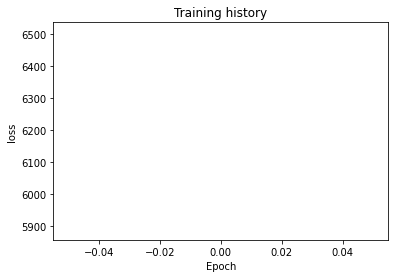

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend()



In [ ]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

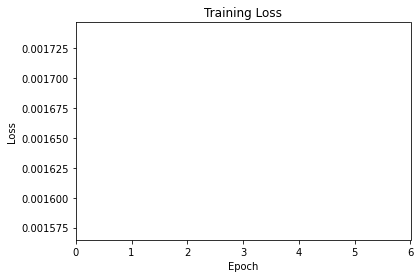

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.legend()
plt.xlim([0, 6]);


In [ ]:
# Validation
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
history_2 = defaultdict(list)
# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy
    history_2['Val_Accuracy'].append(eval_accuracy.item())
    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))





Running Validation...
  Accuracy: 0.89
  Validation took: 0:00:20


Text(0.5, 0, 'Epoch')

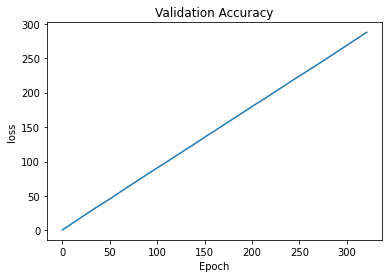

In [ ]:
plt.plot(history_2['Val_Accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))


text1 = df_test.Tweet.values

indices1=tokenizer.batch_encode_plus(text1,
                                     max_length=128,
                                     add_special_tokens=True, 
                                     return_attention_mask=True,
                                     pad_to_max_length=True,
                                     truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = my_mini_batch_size

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)



print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7955
           1       0.75      0.77      0.76      2323

    accuracy                           0.89     10278
   macro avg       0.84      0.85      0.85     10278
weighted avg       0.89      0.89      0.89     10278



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Predicting labels for 3,212 test sentences...


In [ ]:
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

